In [9]:
import torch
import warnings
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
warnings.filterwarnings('ignore')
import time


def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(axis=1,
                          keepdims=True)
    return X_exp/partition

def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y]).mean()


class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, (num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]

    def forward(self, X):
        X = X.reshape((-1, self.W.shape[0]))
        return softmax(torch.matmul(X, self.W)+self.b)
    
    def loss(self, y_hat, y):
        return cross_entropy(y_hat, y)

(105.24842885136604, 19.173718690872192)

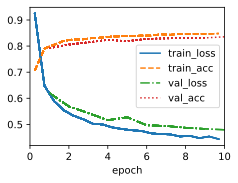

In [2]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

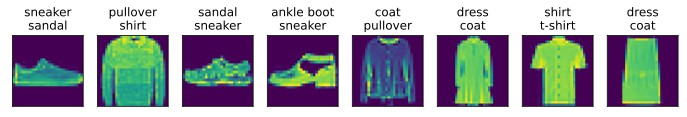

In [4]:
X, y = next(iter(data.val_dataloader()))
preds = model(X).argmax(axis=1)
wrong = preds != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a,b in zip(data.text_labels(y), data.text_labels(preds))]
data.visualize([X,y], labels=labels)

# 4.4.7. Exercises

## 1. In this section, we directly implemented the softmax function based on the mathematical definition of the softmax operation. As discussed in Section 4.1 this can cause numerical instabilities.
- Test whether softmax still works correctly if an input has a value of 100.
- Test whether softmax still works correctly if the largest of all inputs is smaller than -100?
- Implement a fix by looking at the value relative to the largest entry in the argument.

### 1.1 Softmax doesn't work correctly if an input has a value of 100

Exponentiating such large values can result in overflow issues, causing incorrect or undefined results.

In [20]:
def test_softmax(x,f):
    b=f(x)
    print(x)
    print(b,b.sum(axis=1))
    
a = torch.randn((1,5))
b = a.clone()
b[0][0]=100
test_softmax(a, softmax)
test_softmax(b, softmax)

tensor([[0.0753, 0.9708, 1.0132, 0.0360, 0.1840]])
tensor([[0.1238, 0.3030, 0.3162, 0.1190, 0.1380]]) tensor([1.0000])
tensor([[1.0000e+02, 9.7076e-01, 1.0132e+00, 3.5976e-02, 1.8405e-01]])
tensor([[nan, 0., 0., 0., 0.]]) tensor([nan])


### 1.2 softmax doesn't work correctly if the largest of all inputs is smaller than -100

Exponentiating very small or negative values can result in underflow issues, causing incorrect or undefined results.

In [21]:
c = a.clone()
c -=200
test_softmax(a, softmax)
test_softmax(c, softmax)

tensor([[0.0753, 0.9708, 1.0132, 0.0360, 0.1840]])
tensor([[0.1238, 0.3030, 0.3162, 0.1190, 0.1380]]) tensor([1.0000])
tensor([[-199.9247, -199.0293, -198.9868, -199.9640, -199.8159]])
tensor([[nan, nan, nan, nan, nan]]) tensor([nan])


### 1.3 Implement a fix

In [22]:
def softmax_fix(X):
    m = X.max()
    X = X-m
    X_exp = torch.exp(X)
    partition = X_exp.sum(axis=1,
                          keepdims=True)
    return X_exp/partition

test_softmax(a, softmax)
test_softmax(a, softmax_fix)
test_softmax(b, softmax_fix)
test_softmax(c, softmax_fix)

tensor([[0.0753, 0.9708, 1.0132, 0.0360, 0.1840]])
tensor([[0.1238, 0.3030, 0.3162, 0.1190, 0.1380]]) tensor([1.0000])
tensor([[0.0753, 0.9708, 1.0132, 0.0360, 0.1840]])
tensor([[0.1238, 0.3030, 0.3162, 0.1190, 0.1380]]) tensor([1.])
tensor([[1.0000e+02, 9.7076e-01, 1.0132e+00, 3.5976e-02, 1.8405e-01]])
tensor([[1.0000e+00, 9.8091e-44, 1.0229e-43, 3.9236e-44, 4.4842e-44]]) tensor([1.])
tensor([[-199.9247, -199.0293, -198.9868, -199.9640, -199.8159]])
tensor([[0.1238, 0.3030, 0.3162, 0.1190, 0.1380]]) tensor([1.])


## 2. Implement a cross_entropy function that follows the definition of the cross-entropy loss function $\sum{y_i\log{\hat{y}_i}}$.
- Try it out in the code example of this section.
- Why do you think it runs more slowly?
- Should you use it? When would it make sense to?
- What do you need to be careful of? Hint: consider the domain of the logarithm.

### 2.1 Implement a cross_entropy function that follows the definition

In [2]:
def cross_entropy_def(y_hat, y):
    l = torch.matmul(y.type(torch.float32),torch.log(y_hat))
    return l.mean()

class SoftmaxRegressionScratchDefLoss(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, (num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]

    def forward(self, X):
        X = X.reshape((-1, self.W.shape[0]))
        return softmax(torch.matmul(X, self.W)+self.b)
    
    def loss(self, y_hat, y):
        return cross_entropy_def(y_hat, y)
    
def stat_model_time(model, data):
    t0 = time.time()
    trainer = d2l.Trainer(max_epochs=10, plot_flag=False)
    trainer.fit(model, data)
    return time.time() - t0

### 2.2 Why more slowly?

The direct implementation of cross-entropy using the logarithm can run more slowly because it involves performing element-wise multiplication of true labels $y$ and logarithms of predicted probabilities $\log \hat{y}$. This operation can be computationally more expensive, especially for large tensors.

In [4]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
model_def_loss = SoftmaxRegressionScratchDefLoss(num_inputs=784, num_outputs=10,
                                                 lr=0.1)
print(f'orgin model spend:{stat_model_time(model, data):.2f} sec')
print(f'definition loss model spend:{stat_model_time(model_def_loss, data):.2f}: sec')

orgin model spend:77.44 sec
definition loss model spend:78.94: sec


### 2.3 Should you use it? When would it make sense to?

   While the direct implementation is conceptually clear, modern deep learning libraries like TensorFlow and PyTorch offer optimized implementations of cross-entropy loss that handle numerical stability and efficiency issues. These built-in functions are generally faster and less prone to numerical instability. However, implementing cross-entropy manually can be educational to understand its mathematical details and issues related to numerical stability.

### 2.4 What to be careful of

When implementing the logarithm, you should be careful of the domain of the logarithm function. The logarithm is undefined for zero or negative values. To prevent this, it's common to clip predicted probabilities $\hat{y}$ to a small positive value or add a small constant to them before taking the logarithm.
In practice, it's recommended to use the built-in cross-entropy loss functions provided by deep learning libraries, as they are optimized for performance and numerical stability. If you're experimenting or learning, the direct implementation can help you understand the underlying mathematics.

## 3. Is it always a good idea to return the most likely label? For example, would you do this for medical diagnosis? How would you try to address this?

Returning the most likely label based on a model's prediction might not always be the best approach, especially in critical domains like medical diagnosis. While it can be suitable in some scenarios, there are cases where additional considerations and approaches are needed.

In medical diagnosis and similar domains:

1. **Uncertainty and Confidence:** Predictive models often provide a confidence level or probability distribution over different classes. In medical diagnosis, it's important to consider not only the most likely label but also the uncertainty associated with the prediction. A high-confidence prediction might be more reliable than a low-confidence one.

2. **False Positives and False Negatives:** Medical diagnosis often involves binary decisions, like diagnosing a disease or not. The cost of false positives (incorrectly diagnosing a condition) and false negatives (missing a condition) can be substantial. You might need to set a threshold for the predicted probabilities to balance between these types of errors.

3. **Thresholds and Trade-offs:** Depending on the medical context, you might adjust the threshold for making predictions. A more conservative threshold might be chosen to avoid false positives, even if it results in more false negatives, or vice versa.

4. **Ensemble Methods:** Combining predictions from multiple models or methods (ensemble methods) can help improve robustness and accuracy. These methods can capture different aspects of the data and provide more reliable predictions.

5. **Domain Expertise:** In medical diagnosis, the input features and context play a crucial role. Domain experts' input is essential for interpreting the model's predictions and making informed decisions.

6. **Explanability:** In critical domains, it's important to have models that are explainable and interpretable. Understanding why a model made a specific prediction can be crucial for gaining trust and confidence in its results.

7. **Validation and Testing:** Rigorous validation and testing are critical in medical diagnosis. Models should be thoroughly tested on diverse and representative datasets to ensure their reliability and accuracy.

8. **Continuous Monitoring:** Models should be continuously monitored and updated as new data becomes available. Medical conditions and practices can change over time, and models need to stay up to date.

In conclusion, returning the most likely label from a predictive model might not be sufficient or appropriate in domains like medical diagnosis. A combination of uncertainty assessment, domain expertise, adjusting thresholds, and considering the implications of false positives and false negatives are important aspects of making accurate and reliable predictions in critical applications.

## 4. Assume that we want to use softmax regression to predict the next word based on some features. What are some problems that might arise from a large vocabulary?

Using softmax regression for predicting the next word based on features is a common approach in natural language processing. However, when dealing with a large vocabulary, several problems can arise that make the task more challenging. Here are some of the issues you might encounter:

1. **Computational Complexity:** As the vocabulary size grows, the computational cost of training and inference increases significantly. Computing the softmax function involves evaluating the exponentials of each word's score, which can become computationally expensive with a large vocabulary.

2. **Memory Usage:** Large vocabularies require more memory to store the model's parameters and intermediate results during computation. This can lead to memory limitations and slow down the training process.

3. **Sparse Gradients:** In gradient-based optimization algorithms, calculating gradients with respect to the model's parameters becomes challenging when the vocabulary is large. Many words have zero gradients, leading to sparse updates and slower convergence.

4. **Numerical Instabilities:** The softmax function involves exponentiating scores, which can lead to numerical instability when dealing with very large or very small values. This can affect the stability of training and the accuracy of predictions.

5. **Data Sparsity:** In natural language, not all words occur frequently in the training data. This can result in insufficient training samples for some words, leading to poor generalization and overfitting for rare words.

6. **High-Dimensional Space:** When using one-hot encoding for words, the dimensionality of the input space becomes equal to the vocabulary size. This can result in a high-dimensional feature space, making the model more prone to overfitting and less interpretable.

7. **Long Training Time:** Training a softmax regression model with a large vocabulary can take a long time, especially if the training data is also extensive. This can slow down the development and experimentation process.

8. **Need for Subsampling or Hierarchical Softmax:** To address computational and memory challenges, techniques like subsampling (selecting a subset of frequent words) or hierarchical softmax (organizing words in a tree structure) can be used. However, these techniques introduce their own complexities.

To address these problems, researchers have proposed various techniques, such as using approximate softmax methods, using subword units (like subword tokenization), or utilizing pre-trained embeddings like Word2Vec, GloVe, and Transformer-based models. These approaches aim to mitigate the challenges posed by large vocabularies and improve the efficiency and effectiveness of language models.

## 5. Experiment with the hyperparameters of the code in this section. In particular:
- Plot how the validation loss changes as you change the learning rate.
- Do the validation and training loss change as you change the minibatch size? How large or small do you need to go before you see an effect?

### 5.1 validation loss with different learning rate

In [12]:
data = d2l.FashionMNIST(batch_size=256)
lrs = [0.001,0.01,0.03,0.1,0.3,1]
train_loss, valid_loss = [],[]
for lr in lrs:
    model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=lr)
    trainer = d2l.Trainer(max_epochs=20, plot_flag=False)
    temp = trainer.fit(model, data)
    train_loss.append(temp[0])
    valid_loss.append(temp[1])

In [ ]:
plt.subplot(1,2,1)
plt.plot(lrs, train_loss, label='train_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(lrs, valid_loss, label='valid loss')
plt.legend()
plt.show()

### 5.2 validation and train loss with different batch size

In [ ]:
batches = d2l.gen_logrithm_nums(initial_value=1, growth_factor=2,
                                num_elements=12)
train_loss, valid_loss = [],[]
for batch in batches:
    data = d2l.FashionMNIST(batch_size=batch)
    model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
    trainer = d2l.Trainer(max_epochs=20, plot_flag=False)
    temp = trainer.fit(model, data)
    train_loss.append(temp[0])
    valid_loss.append(temp[1])

In [ ]:
plt.subplot(1,2,1)
plt.plot(lrs, train_loss, label='train_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(lrs, valid_loss, label='valid loss')
plt.legend()
plt.show()